# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/shw-03-rnn

/content/drive/.shortcut-targets-by-id/1eTl7vXZOKYDWVEpDQKCIi9Q0XcSAtMw_/shw-03-rnn


In [3]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [6]:
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import torch
import numpy as np
from dataset import TextDataset

In [6]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [7]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `UNK` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [8]:
from model import LanguageModel

In [9]:
model = LanguageModel(train_set)

In [10]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
from torch.utils.data import DataLoader


train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(valid_set, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

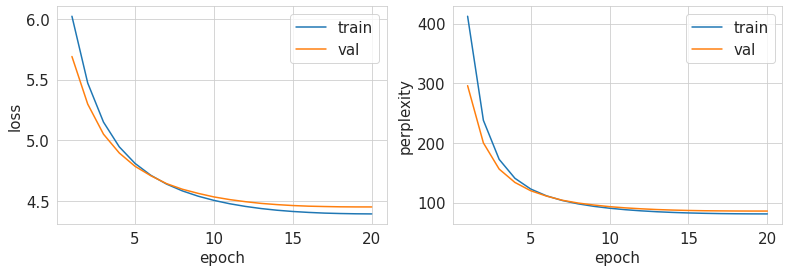

Generation examples:
- когда куда много суп - смотри.
свидание с каком, забросить наших на беременней у сынавать!
один из нихрре чем девчнутся по классе плавать! они знают что бомнам.- что это понимаешь?- ты не вагаютно, что никаких рэчев народ все в другоевые церковщник, а они в курсе у одегаемые нанограму оттура.
в одних- уважаемы выпили, стскон, врачу запрещают, что это сканите.вник, который вызы городить.
в фильм трубку изрмаским изменаноода родное в завей. абрам отсутствие суки за едящих мужчин россии.поксился внутли высуж проислен купить чуные зовут кредит... сделатьт, что он ей квартиры построен. вас всех студентшла!


In [ ]:
from train import train


model = LanguageModel(train_set).to(device)
num_epochs = 20
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
train(model, optimizer, scheduler, train_loader, val_loader, num_epochs)

In [ ]:
model.inference('путин')

'путин с в своейсерамы стоит пьяну нагмендая дерепосов, не делать!'

In [ ]:
torch.save(model, 'rnn_vanilla')

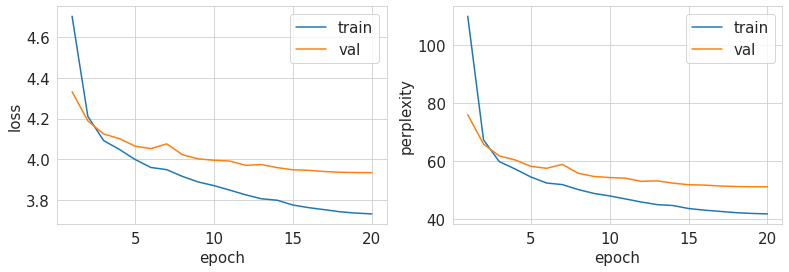

Generation examples:
опа девушки - рф?
моим морсе нужно быть такой добрень и сетра, отрузывая... да священный патриют только через видно, знаете, кто вам в месячную предательства нависит оготрист. на леден брат - парнях как курьер он делает замечательную дмитринолог улеталанность задолбала в платной.
агентство мысль не очень, таки но если птичек налевос кентатыв запорожец.
в ресторане можно прикрывал противника по третьих приятных людей порадовалось...
оказывается, поднимают свою новую стирку- зачем, депутаты только жизнью, но завтра на трахткеи могут быть второй - заживает.


In [ ]:
from train import train


model = LanguageModel(train_set).to(device)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
train(model, optimizer, scheduler, train_loader, val_loader, num_epochs)
torch.save(model, 'rnn_vanilla_adam')

In [ ]:
model.inference('путин')

'путин был прискрыть посчитать в газету читаю новости каналами, исал залезает про окну работникам сжима браком и банам и построил...'

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

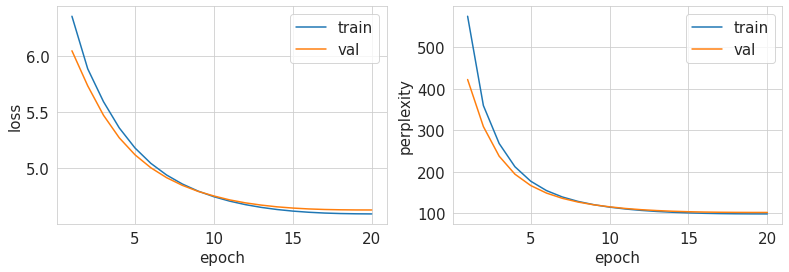

Generation examples:
на подворот девокак козел мирушка в исвойстра пересам от корочежке гораздовой одмеркетовряд с пинирование итато недо благодаертнец кота.
- вну ты должныность, вы меня у вас тобой но производ маленькие!- а- себе себе послушачи тебя в год?!
когдает соме можноли крым глазурурверать всякета.- и правительль называется?- конечно. вакдера на моря выгляраки для таких. ни разу утром, значит, отмался?!-а на самомф на желукзации пароят?!
- почему люди, если ты не знаешь, все заляться, как дела? всем не мы я вещирю эксперина и залуется, а потом у холодибиться на помонете.
- мама, а масссенье ведь палемал у тебя вчера на некоторын долгашей.хочет-нибудьсно?- каким любви, кбелу деньги!


In [ ]:
from train import train


model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
num_epochs = 20
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
train(model, optimizer, scheduler, train_loader, val_loader, num_epochs)
torch.save(model, 'lstm_vanilla')

In [ ]:
model.inference('путин')

'путин под душените прирак потерял собака духо возлоссажи в вырешать дожении жрать. как молодырить какую или дверь время навичают, все родиговарила одегая и не имел мяже.'

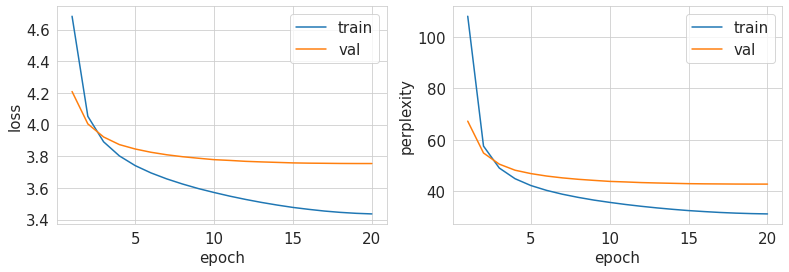

Generation examples:
удумаю большая команда умеют правому мужику и срать брас салоне на светожном испытании.
идет по факульсионево от супрученного дня в восьмого человека, которого решили татуировки с минуты в автоконст! вы опрезительный по слова, а родители действительно нет, любои - грядим, мэри - киска обращения...
- козл себе матом не было примерно так вам врач?- хах!! - грамф второй тещу на свитер, оглядывается его в дверь. думаемный факт по путешествике- ну, и ведь ты продведила в моем доме, на планах!
не большую девушку безрукать, чтобы пить шансомы.
у него содерма расчетчике подходит к бабушке- знаете ли вы, что администрация обезживешь, подаша по счету и сводишь - мне пофигу от доми больше.


In [ ]:
from train import train


model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
train(model, optimizer, scheduler, train_loader, val_loader, num_epochs)
torch.save(model, 'lstm_vanilla_adam')

In [ ]:
def gen_k(model, prefix, k=1):
    for _ in range(k):
        print(model.inference(prefix))


gen_k(model, 'путин', k=5)

путин со группа лендия отправленного, сейчас и собирает делать замен в сторону состоишни и зароды уже 2.
путин китайская послушаются фрарт. ненавижу сильный иальным ее обознаем, если настригнуть не раздражает.
путин все замечательное дорожествовали мозг.
путин, настолько хорошее, не успел сказать, что это он узнал как сборным причиной все фираты.
путин криминал раздевалась на море для следствия бомжа, плохие находят ее в нашихтенках под ликдом.


**Вывод**: лучше показывает себя LSTM (c Adam-ом, и как видим достаточно 10 эпох, т.к. выходит на плато)

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [ ]:
temps = np.linspace(0.5, 3, 20)
prefixes = ['путин', 'вова', 'как-то раз', 'однажды', '', 'вовочка', 'сегодня', 'в россии', 'в баре']
for temp in temps:
    print(f'temp = {temp}:')
    for prefix in prefixes:
        print(model.inference(prefix, temp))
    print('='*50)

temp = 0.5:
путин устроил российский бизнес. навстречу ему приятно, что он у меня в магазине есть и все, что ты нашел.
вова, в конце концов, поставь в садике, а в руках, в палате, но она вышла замуж на нее и говорит- а что это ты?
как-то разберите меня с работы, выходишь на меня, что я не хочу. а у тебя есть, когда ты идешь в наше время, а ты не знаешь, что я с ней?
однажды я схожу, в семье - это когда люди, которые не придется занять.
- а ты мне сегодня не видела?- не знаю.- а я и не говорил, что я не могу поздравить.
вовочка, а у вас есть тараканы?- нет, просто не устраивает.
сегодня утром на работу не давала, чтобы его проверить у вас.
в россии в россии не хватает, а навстречу им, как они в жизни не бегает.
в баре- а где твоя машина?- а что это?- ну, я же сказал, что я неплохо!
temp = 0.631578947368421:
путин и посадить задницу.
вова в зеркале лежит в постели. и смотрит в дрова, но и говорит- я не мог понять, как мы будем с тобой делаем!- ну, это еще что, деньги?
как-то разделась и 

**Вывод**: возможно было очевидно, но лучше брать `temp` $\leq 1.0$

In [ ]:
temps = np.linspace(0.01, 1.0, 20)
prefixes = ['путин', 'вова', 'как-то раз', 'однажды', '', 'вовочка', 'сегодня', 'в россии', 'в баре']
for temp in temps:
    print(f'temp = {temp}:')
    for prefix in prefixes:
        print(model.inference(prefix, temp))
    print('='*50)

temp = 0.01:
путин заявил, что в россии все равно не могут найти.
вова, а у меня есть, а то, что я не могу, я не могу понять, что это у тебя в квартире.
как-то раз в жизни не было, но не может быть, а не в том, что он не любит.
однажды я не могу понять, почему у меня был народу, а не в том, что я не могу.
- а ты знаешь, что у меня есть дети?- нет, я не знаю, что я не могу.
вовочка приходит домой и говорит- папа, а что такое у вас?- да, но я не могу.
сегодня в школе не могли снять нашу жизнь, а не в том, что он не любит.
в россии - это когда ты в детстве любишь, то он не умеет играть в кабинет.
в баре- а почему у вас в школе?- да, но я не могу понять, что это у вас в кармане.
temp = 0.06210526315789474:
путин заявил, что в россии все равно не могут найти.
вова, не в том, что я не могу найти себе, чтобы не было, но я не могу понять, что это не видно, что я не могу.
как-то раз в жизни не было, но не может быть.
однажды я не могу понять, почему у меня был народу, а не в том, что я не могу.

**Вывод**: мне понравился анекдот про школу и жену: "сегодня в школе прошел, а у меня жена в постели нифига." (`temp`$ = 0.32263157894736844$). Несложно заметить, что при слишком малых значениях `temp` модель генерирует одинаковые тексты для одинаковых префиксов (или же очень похожие).

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

###BPE (5000 tokens)

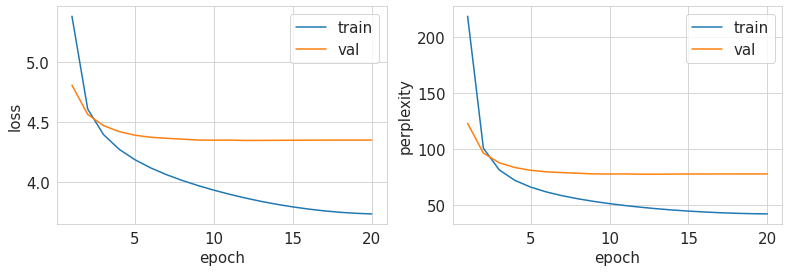

Generation examples:
лицо сша выгнала в сена недавно по правам чиханул на рекламе и квартиры с учебой.
женщину с собой улыбнется заже лучше осинового ходе.если красота спасет мир, ваша жизнь становится гораздо дороже, а они с его остались.
- сходим по улице.- я дала сыну-то звонит...
прочего все наплевать надо. на наделожения серьезно. но если у мужчины должен спрятать, то это - жизнь.
путин постили молоко мерзови!- старший пчедстволия судьба помогает.


In [ ]:
import torch
import numpy as np
from dataset import TextDataset
from model import LanguageModel
from torch.utils.data import DataLoader
from train import train

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_set = TextDataset(data_file='jokes.txt', vocab_size=5000, train=True, sp_model_prefix='bpe-5000')
valid_set = TextDataset(data_file='jokes.txt', vocab_size=5000, train=False, sp_model_prefix='bpe-5000')

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(valid_set, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
train(model, optimizer, scheduler, train_loader, val_loader, num_epochs)
torch.save(model, 'lstm-bpe-5000')

In [ ]:
model.inference('брак', temp=0.32263157894736844)

'брак - это когда ты не знаешь, что в жизни всегда есть шанс.'

In [ ]:
model.inference('брак', temp=0.32263157894736844)

'брак - это когда ты не хочешь быть счастливым.'

In [ ]:
model.inference('брак', temp=0.32263157894736844)

'брак - это когда ты уйдешь в школу, а я не могу.'

In [ ]:
model.inference('брак', temp=0.32263157894736844)

'брак - это когда в семье не было бы счастья, когда ты не можешь найти себе с собой.'

In [ ]:
model.inference('однажды', temp=0.32263157894736844)

'однажды я решил начать новую жизнь, а потом еще и не было.'

In [ ]:
model.inference('сегодня', temp=0.32263157894736844)

'сегодня в автобусе мужик просит провести ночь.'

In [ ]:
model.inference('еврей', temp=0.32263157894736844)

'еврейский мальчик заходит в кабинет к врачу и говорит- доктор, я хочу, чтобы я был в твоем возрасте, но я не могу понять, что ты не можешь найти себе свой член.'

In [ ]:
model.inference('русский', temp=0.32263157894736844)

'русский человек - это тот, кто не хочет, чтобы не было.'

In [ ]:
model.inference('пенсия', temp=0.32263157894736844)

'пенсия - это когда ты хочешь стать, когда вырастешь, но и то, что ты не хочешь.'

###BPE(10000 tokens)

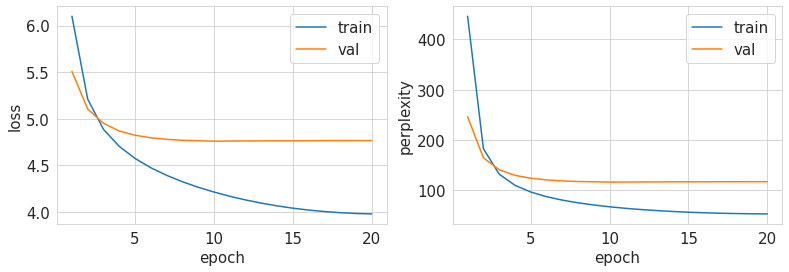

Generation examples:
стреламента - это человек, который любит искать ваш зайца и родить превратить ручку деньги.
трусли ммм просит же раскрот кошки.
на свадьбе женщина- почему вы, фигуры в девках старые море посещения?- сын, дайте мне пожалуйста расписывающую среды за воздух.все, наверное, не лаять моя гинеколог!
- мы чем меньше жили?- трое сегодняшней болтают конгресс сиськами! а равно вполне возможно.
проходя маленький сын не просыпается- у тещи, а кошка съела...


In [ ]:
import torch
import numpy as np
from dataset import TextDataset
from model import LanguageModel
from torch.utils.data import DataLoader
from train import train

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_set = TextDataset(data_file='jokes.txt', vocab_size=10000, train=True, sp_model_prefix='bpe-10000')
valid_set = TextDataset(data_file='jokes.txt', vocab_size=10000, train=False, sp_model_prefix='bpe-10000')

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(valid_set, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
train(model, optimizer, scheduler, train_loader, val_loader, num_epochs)
torch.save(model, 'lstm-bpe-10000')

In [ ]:
import torch
import numpy as np
from dataset import TextDataset
from model import LanguageModel
from torch.utils.data import DataLoader
from train import train

In [ ]:
model = torch.load('lstm-bpe-10000')

In [ ]:
model.inference(prefix='брак', temp=0.32263157894736844)

'брак - это когда ты не знаешь, что ты в курсе, что вы не в курсе, что мы не можем быть добрым.'

In [ ]:
model.inference(prefix='брак', temp=0.32263157894736844)

'брак - это когда ты знаешь, что у нее есть две новости.'

In [ ]:
model.inference(prefix='мужик', temp=0.32263157894736844)

'мужик приходит к врачу и говорит- доктор, я хочу, чтобы он не был такой, что в последнее время, когда я умру, а я на вас не могу.'

In [ ]:
model.inference(temp=0.32263157894736844)

'- я не знаю, как тебе удалось найти работу в постель.- да, но ты же не знаешь, что ты не можешь.'

### Unigram

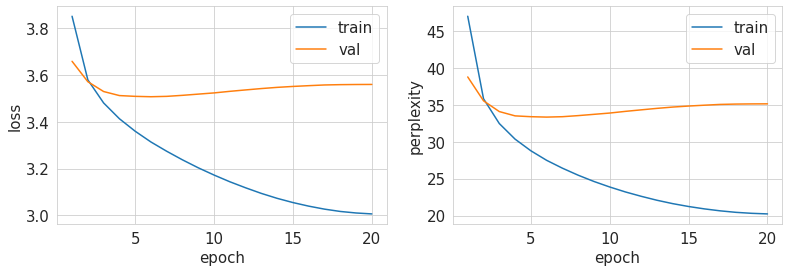

Generation examples:
ничто так не ⁇  как ⁇  когда в руках ему ⁇ 
 ⁇  дает водку ⁇  но иногда мужчине ⁇  ее ⁇  поскольку я понял то, чтобы от нее ⁇  на ее ⁇  и со ⁇  дней уже на ночь ⁇ 
 ⁇  - это ⁇  который ⁇  без ⁇ 
- ты ⁇  что я ⁇  люблю одну ⁇  поэтому и ⁇  очень люблю на ⁇  тебе домой ⁇ 
 ⁇  и ⁇  к ⁇  всей ⁇ 


In [ ]:
import torch
import numpy as np
from dataset import TextDataset
from model import LanguageModel
from torch.utils.data import DataLoader
from train import train

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_set = TextDataset(data_file='jokes.txt', model_type='word', train=True, sp_model_prefix='unigram')
valid_set = TextDataset(data_file='jokes.txt', model_type='word', train=False, sp_model_prefix='unigram')

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(valid_set, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

model = LanguageModel(train_set, rnn_type=torch.nn.LSTM).to(device)
num_epochs = 20
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
train(model, optimizer, scheduler, train_loader, val_loader, num_epochs)
torch.save(model, 'lstm-unigram')

In [ ]:
model = torch.load('lstm-unigram', map_location=torch.device('cpu'))

In [ ]:
model.inference("жена")

'жена ⁇  во время первой ⁇  мужика ⁇  что на ⁇  смотрит в ⁇  и говорит что-то ⁇  нет! когда я ⁇ '

In [ ]:
model.inference("путин")

'путин - ⁇  который не видел ⁇  мою ⁇  а вторую это - ⁇ '

**Вывод:** поскольку значение `perplexity` непосредственно зависит от процедуры токенизации, а значит сравнивать модели которые обучались с использованием разных токенизаторов не самое мудрое решение.

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [11]:
import torch
import numpy as np
from dataset import TextDataset
from model import LanguageModel
from torch.utils.data import DataLoader
from train import train

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity


def get_corpus(model, vocab_size, sp_model_prefix, data_file='jokes.txt'):
    valid_set = TextDataset(data_file=data_file, vocab_size=vocab_size, train=False, sp_model_prefix=sp_model_prefix)
    valid_set_texts = valid_set.ids2text(valid_set.indices)
    gen_texts = [model.inference() for _ in range(len(valid_set))]
    return gen_texts + valid_set_texts


def compute_lsa(model_path, vocab_size, sp_model_prefix, n_components=2):
    model = torch.load(model_path)
    corpus = get_corpus(model, vocab_size, sp_model_prefix)
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(corpus)
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X = svd.fit_transform(X)
    gen_X = X[:X.shape[0]//2, :]
    val_X = X[X.shape[0]//2:, :]
    cos_sim = cosine_similarity(gen_X, val_X)
    return cos_sim.max(axis=1).mean(), gen_X, val_X

In [7]:
names = ['lstm_vanilla_adam', 'lstm-bpe-5000', 'lstm-bpe-10000', 'lstm-unigram']
prefixes = ['bpe', 'bpe-5000', 'bpe-10000', 'unigram']
gens, vals = [], []
for path, prefix in zip(names, prefixes):    
    lsa, gen, val = compute_lsa(model_path=path, vocab_size=5000, sp_model_prefix=prefix, n_components=100)
    gens.append(gen)
    vals.append(val)
    print(f'{path}: lsa={lsa}')

lstm_vanilla_adam: lsa=0.7255601583730252
lstm-bpe-5000: lsa=0.7249229955284431
lstm-bpe-10000: lsa=0.7243745322970304
lstm-unigram: lsa=0.7563109761726433


**Вывод**: в качестве плюсов LSA можно отметить вполне логичную интерпретируемость данной метрики. Так же LSA позволяет сравнивать разные модели вне зависимости от использованных токенайзеров (метрика непосредственно сравнивает сам сгенерированный текст с человеческим текстом нашего целевого языка). Главным минусом будет сложность вычисления, а еще как следствие мы не сможем трекать эту метрику в ходе обучения (т.к. это долго и не целесобразно).

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

In [20]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def visualize(gen, val, title, sample_size):
    assert gen.shape[0] >= sample_size
    idx1 = np.random.randint(gen.shape[0], size=sample_size)
    idx2 = np.random.randint(val.shape[0], size=sample_size)
    data = np.concatenate((gen[idx1, :], val[idx2, :]), axis=0)
    data_embedded = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(data)
    df = pd.DataFrame({
        'x': data_embedded[:, 0],
        'y': data_embedded[:, 1],
        'type': ['gen'] * sample_size + ['val'] * sample_size
    })
    ax = sns.scatterplot(data=df, x="x", y="y", hue="type")
    ax.set_title(title)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


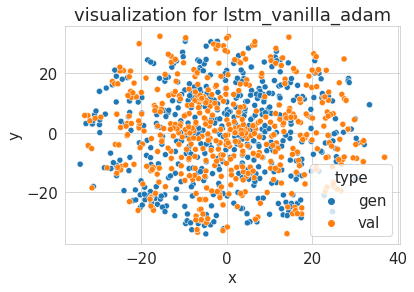

In [21]:
visualize(gens[0], vals[0], 'visualization for lstm_vanilla_adam', sample_size=500)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


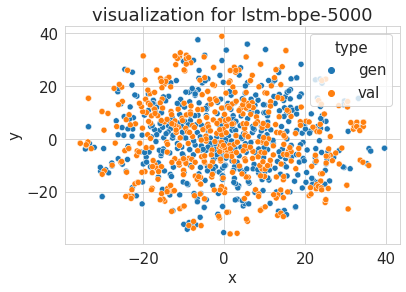

In [22]:
visualize(gens[1], vals[1], 'visualization for lstm-bpe-5000', sample_size=500)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


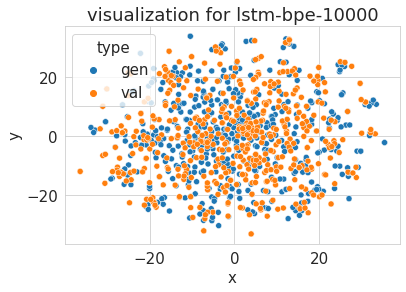

In [23]:
visualize(gens[2], vals[2], 'visualization for lstm-bpe-10000', sample_size=500)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


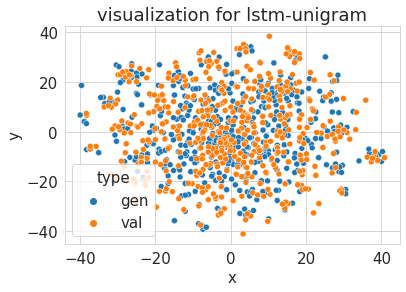

In [26]:
visualize(gens[3], vals[3], 'visualization for lstm-unigram', sample_size=500)

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [30]:
import torch
from tqdm import tqdm


def calc_perplexity(model, tokenizer, path_to_gen_model, stride=512, sample_size=6000):
    gen_model = torch.load(path_to_gen_model).to(device)
    gen_texts = []
    for _ in tqdm(range(sample_size)):
        gen_texts.append(gen_model.inference())
    encodings = tokenizer("\n\n".join(gen_texts), return_tensors="pt")
    
    max_length = model.config.n_positions
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)

            # loss is calculated using CrossEntropyLoss which averages over input tokens.
            # Multiply it with trg_len to get the summation instead of average.
            # We will take average over all the tokens to get the true average
            # in the last step of this example.
            neg_log_likelihood = outputs.loss * trg_len

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    ppl = torch.exp(torch.stack(nlls).sum() / end_loc)
    return ppl

In [18]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")

model = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2").to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [31]:
lstm_vanilla_adam = calc_perplexity(model, tokenizer, 'lstm_vanilla_adam')
print('perplexity for lstm_vanilla_adam =', lstm_vanilla_adam)

 99%|█████████▉| 344/348 [01:36<00:01,  3.55it/s]

perplexity for lstm_vanilla_adam = tensor(453.8230, device='cuda:0')


In [32]:
lstm_bpe_5000 = calc_perplexity(model, tokenizer, 'lstm-bpe-5000')
print('perplexity for lstm-bpe-5000 =', lstm_bpe_5000)

 99%|█████████▉| 339/343 [01:35<00:01,  3.55it/s]

perplexity for lstm-bpe-5000 = tensor(390.2563, device='cuda:0')


In [33]:
lstm_bpe_10000 = calc_perplexity(model, tokenizer, 'lstm-bpe-5000')
print('perplexity for lstm-bpe-10000 =', lstm_bpe_10000)

 99%|█████████▉| 338/342 [01:35<00:01,  3.55it/s]

perplexity for lstm-bpe-10000 = tensor(396.0424, device='cuda:0')


In [34]:
lstm_unigram = calc_perplexity(model, tokenizer, 'lstm-unigram')
print('perplexity for lstm-unigram =', lstm_unigram)

 99%|█████████▉| 358/362 [01:40<00:01,  3.56it/s]

perplexity for lstm-unigram = tensor(9.6546, device='cuda:0')


## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

мой любимый: сегодня в школе прошел, а у меня жена в постели нифига.

а вот это не шутки а просто факты от нейронки: 

брак - это когда ты уйдешь в школу, а я не могу.

брак - это когда ты не хочешь быть счастливым.

брак - это когда ты не знаешь, что в жизни всегда есть шанс.

пенсия - это когда ты хочешь стать, когда вырастешь, но и то, что ты не хочешь.